In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import nn, data as gdata, loss as gloss
import numpy as np
import time

In [4]:
# 读取数据
def get_data_ch7():
    data = np.genfromtxt('C:\\Users\\kenya\\Desktop\\d2l-zh\\data\\airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return nd.array(data[:1500, :-1]), nd.array(data[:1500, -1])

features, labels = get_data_ch7()
features.shape

(1500, 5)

In [5]:
# 随机梯度下降
def sgd(params, states, hyperparams):
    for p in params:
        p[:] -= hyperparams['lr'] * p.grad

In [6]:
# 通用训练函数
def train_ch7(trainer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = d2l.linreg, d2l.squared_loss
    w = nd.random.normal(scale=0.01, shape=(features.shape[1], 1))
    b = nd.zeros(1)
    w.attach_grad()
    b.attach_grad()

    def eval_loss():
        return loss(net(features, w, b), labels).mean().asscalar()

    ls = [eval_loss()]
    data_iter = gdata.DataLoader(
        gdata.ArrayDataset(features, labels), batch_size, shuffle=True)
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            with autograd.record():
                l = loss(net(X, w, b), y).mean()  # 使用平均损失
            l.backward()
            trainer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.243936, 0.080950 sec per epoch


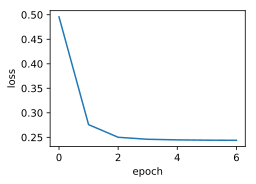

In [7]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

# 梯度下降
train_sgd(1, 1500, 6)

loss: 0.242622, 4.001748 sec per epoch


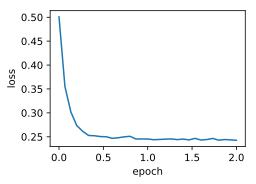

In [8]:
# 随机梯度下降

train_sgd(0.005, 1)

loss: 0.242606, 0.445722 sec per epoch


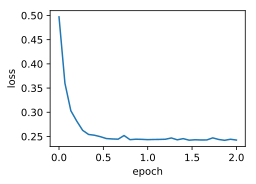

In [9]:
train_sgd(0.05, 10)

In [10]:
def train_gluon_ch7(trainer_name, trainer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma=0.01))
    loss = gloss.L2Loss()

    def eval_loss():
        return loss(net(features), labels).mean().asscalar()

    ls = [eval_loss()]
    data_iter = gdata.DataLoader(
        gdata.ArrayDataset(features, labels), batch_size, shuffle=True)
    # 创建Trainer实例来迭代模型参数
    trainer = gluon.Trainer(
        net.collect_params(), trainer_name, trainer_hyperparams)
    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)  # 在Trainer实例里做梯度平均
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    d2l.set_figsize()
    d2l.plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    d2l.plt.xlabel('epoch')
    d2l.plt.ylabel('loss')

loss: 0.242778, 0.452806 sec per epoch


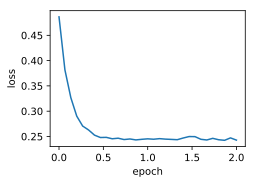

In [11]:
train_gluon_ch7('sgd', {'learning_rate': 0.05}, features, labels, 10)